# Optimum Integral Design: Python Version:

## 1. Imports and Definitions:

In [1]:
import numpy as np
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from scipy.stats import norm
import panel as pn
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [2]:
# Max harmonic we want the calculation to go up to:
# 1 = dipole, 2 = quadrupole, 3 = sextupole, etc.
n_max = 5
# Current magnitude
I0 = 16000 
# Vacuum permeability
mu0 = 4 * np.pi * 1e-7 
# Radius from origin as starting point (inner layer)
# Outter radius is controlled by amount of condutors present in block
r0 = 2 
# Total number of blocks (divide by 4 to get number of blocks per quadrant)
num_conductors = 32 
# Number of conductors per block
n_radial = 5 
# Radial spacing between conductors
dr = 0.2 

## 2. Magnetic Field Definition:

We define the magnetic field series based on the following definition:

* For $r<a$:
  * $\large{B_r= \dfrac{\mu_0 I}{2\pi a} \displaystyle\sum_{n=1}^{\infty}\left( \frac{r}{a} \right)^{n-1}\sin[n(\phi-\theta)]}$
  * $\large{B_{\theta}= -\dfrac{\mu_0 I}{2\pi a} \displaystyle\sum_{n=1}^{\infty}\left( \frac{r}{a} \right)^{n-1}\cos[n(\phi-\theta)]}$
  * $\large{B_z=0}$
* For $r>a$:
  * $\large{B_r= \dfrac{\mu_0 I}{2\pi a} \displaystyle\sum_{n=0}^{\infty}\left( \frac{a}{r} \right)^{n+1}\sin[n(\phi-\theta)]}$
  * $\large{B_{\theta}= \dfrac{\mu_0 I}{2\pi a} \displaystyle\sum_{n=0}^{\infty}\left( \frac{a}{r} \right)^{n+1}\cos[n(\phi-\theta)]}$
  * $\large{B_z=0}$

We note that $a$ is the magnitude of the position vector of the conductor, and $r$ is the magnitude of the position vector of the point where we are calculating the field.

We convert these values to Cartesian coordinates for plotting using the following transformation:
* $\begin{pmatrix} B_x \\ B_y \end{pmatrix} = \begin{pmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{pmatrix} \begin{pmatrix} B_r \\ B_{\theta} \end{pmatrix} \implies \left\{ \begin{array}{l} B_x = B_r \cos\theta - B_{\theta} \sin\theta \\ B_y = B_r \sin\theta + B_{\theta} \cos\theta \end{array} \right.$

Now, we can define this magnetic field definition in our code.

We start by defining the B-field at a point $(x_a, y_a)$ due to a conductor at $(x, y)$ with a current $I$ running through it.

In [3]:
def B_harm(x, y, x_a, y_a, I):
    # Position of the conductor
    a = np.sqrt(x_a**2 + y_a**2)
    # Position of field measurement
    r = np.sqrt(x**2 + y**2)

    # Angle between a and y=0
    phi = np.arctan2(y_a, x_a)
    # Angle between r and y=0
    theta = np.arctan2(y, x)

    # Angle between r and a
    ang = phi - theta

    # Replace r=0 with r=1e-20 to avoid divsion by zero
    r = np.where(r == 0, 1e-10, r)

    # Now we compute the field for both cases, adding up harmonics until the n_max harmonic is calculated and added

    # Case for r < a:
    B_r_in = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(r / a)**(n - 1) * np.sin(n * ang) for n in range(1, n_max+1)], axis=0)
    B_theta_in = (-1)*((mu0 * I) / (2 * np.pi * a)) * np.sum([(r / a)**(n - 1) * np.cos(n * ang) for n in range(1, n_max+1)], axis=0)
    
    # Case for r > a:
    B_r_out = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(a / r)**(n + 1) * np.sin(n * ang) for n in range(0, n_max+1)], axis=0)
    B_theta_out = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(a / r)**(n + 1) * np.cos(n * ang) for n in range(0, n_max+1)], axis=0)

    # Use np.where to select the correct field values to return
    # np.where(cond., x, y) -> # If true, takes x; if false, takes y
    B_r = np.where(r > a, B_r_out, B_r_in) 
    B_theta = np.where(r > a, B_theta_out, B_theta_in)

    # Convert to cartesian coordinates (notably using the angle theta, not ang)
    B_x = B_r * np.cos(theta) - B_theta * np.sin(theta)
    B_y = B_r * np.sin(theta) + B_theta * np.cos(theta)

    return B_x, B_y

Next, we define a function to determine each $n$th component of the field, which will allow us to isolate the field components:

In [4]:
def B_harm_indiv(x, y, x_a, y_a, I, n):
    a = np.sqrt(x_a**2 + y_a**2)
    r = np.sqrt(x**2 + y**2)

    phi = np.arctan2(y_a, x_a)
    theta = np.arctan2(y, x)
    ang = phi - theta

    r = np.where(r == 0, 1e-10, r)

    B_r_out = ((mu0 * I) / (2 * np.pi * a)) * (a / r)**(n + 1) * np.sin(n * ang)
    B_theta_out = ((mu0 * I) / (2 * np.pi * a)) * (a / r)**(n + 1) * np.cos(n * ang)

    B_r_in = ((mu0 * I) / (2 * np.pi * a)) * (r / a)**(n - 1) * np.sin(n * ang)
    B_theta_in = (-1) * ((mu0 * I) / (2 * np.pi * a)) * (r / a)**(n - 1) * np.cos(n * ang)

    B_r = np.where(r > a, B_r_out, B_r_in)
    B_theta = np.where(r > a, B_theta_out, B_theta_in)

    B_x = B_r * np.cos(theta) - B_theta * np.sin(theta)
    B_y = B_r * np.sin(theta) + B_theta * np.cos(theta)

    return B_x, B_y

## 4. Conductor Distribution:

In order to map the conductors to follow a density distribution of $\cos\theta$, I perform *inverse transform sampling*. This methodology allows me to distribute a sample according to a specific density function. I conduct this sampling in the region $\theta\in [-\frac{\pi}{2}, \frac{\pi}{2}]$. Once I have this distribution, I mirror it across the y-axis by subtracting each angle by $\pi$.

We require that the density of conductors, $f$, follow the form: $f(\theta) \propto\cos\theta$

From here, we can derive an analytical form for the density function by noting that the probability density function (PDF) must equal one when taken over the entire region. Thus, if we assume there exists some normalization constant $X$ such that $f(\theta)=X \cos\theta$, then we can compute the value of $X$:

$$ \int_{-\pi /2}^{\pi /2} X \cos\theta d\theta=1\implies X=\frac{1}{2}\implies f(\theta)=\frac{1}{2}\cos\theta$$

This density function makes sense, as it is largest at $\theta=0$ and smallest at $\theta=-\frac{\pi}{2}$ and $\theta=\frac{\pi}{2}$.

Now that we have the density function that describes the distribution, we need to map this over the region.

To do this, I find the cummulative distribution function (CDF), and then invert it. Whereas the PDF tells us the probability density at each point (how likely values are around that point), the CDF tells us the total probability accumulated up to that point. As such, the CDF goes from $0$ to $1$. To calculate the CDF, we just need to integrate the pdf to some arbitraty $\theta$ value:

$$ F(\theta) = \int_{-\pi/2}^{\theta} \frac{1}{2}\cos t dt \implies F(\theta) = \frac{1+\sin\theta}{2}$$

The CDF gives the probability that a random angle $\theta_r$ is less than or equal to a specific angle $\theta$. By inverting the CDF, we can find the specific angle $\theta$ that corresponds to any given cumulative probability between 0 and 1. The inverse CDF, $u$, can be found by simply inverting the CDF:

$$ u=F(\theta)\implies u = \frac{1+\sin\theta}{2} \implies \theta(u) = \arcsin(2u-1)$$

This function of $\theta(u)$ tells us how we should distribute our angles, which will allow us to distribute our conductors and then reflect this distribution:

In [5]:
# List of angles following a cosine theta distribution, symmetric about y axis

# Total number of conductors per side
half_conductors = num_conductors // 2 

# Uniformly spaced cumulative values (excluding 0 and 1 to avoid endpoints)
u = np.linspace(0, 1, half_conductors + 2)[1:-1]

# Inverse CDF: arcsin(2u - 1) maps uniform u to theta
theta_right = np.arcsin(2 * u - 1)         # Right side: theta in [-π/2, π/2]
theta_left = np.pi - theta_right           # Reflect to left side for symmetry

theta_list = np.sort(np.concatenate([theta_right, theta_left]))

# Determines the position of the conductors from the given angles
radii = [r0 + i * dr for i in range(n_radial)]

# Maps out the wires and how they should be distributed
# Current stays constant in magntitude for each conductor
wire_params = []
for theta in theta_list:
    for r in radii:
        x = r * np.cos(theta)
        y = r * np.sin(theta)

        # Determine current direction by quadrant
        if x > 0:
            current = (-1)*I0  # Q1 & Q4 (right side)
        elif x < 0:
            current = I0   # Q2 & Q3 (left side)
        else:
            current = 0  # Edge case — not expected
        wire_params.append((x, y, current))

## 5. Total Field Calculation & Plotting:

Now that we have the conductors distributed, we can calculate the total field contribution due to these points up to the given harmonic. 

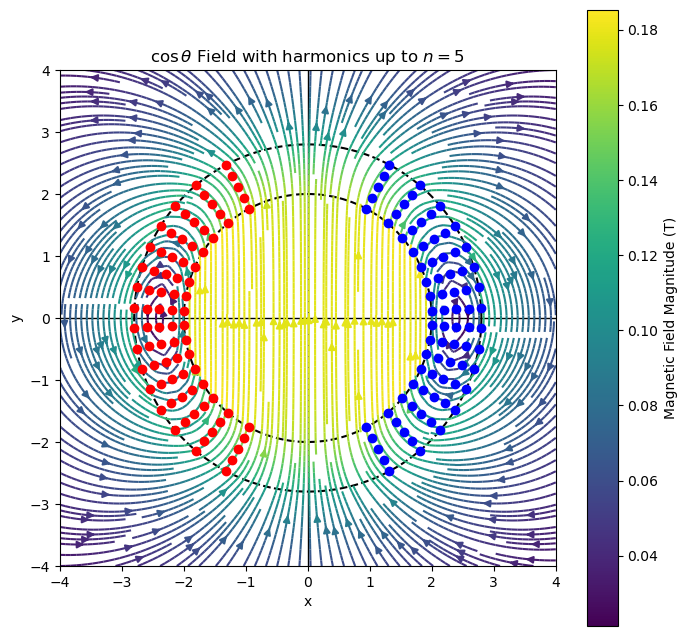

In [6]:
# B-field components are computed

# We set them up as arrays with the same dimensions as X and Y

# Grid setup
x = np.linspace(-4, 4, 250)
y = np.linspace(-4, 4, 250)
X, Y = np.meshgrid(x, y)

Bx_total = np.zeros_like(X)
By_total = np.zeros_like(Y)

# Calculate field for each wire component
for x0, y0, I in wire_params:
    Bx, By = B_harm(X, Y, x0, y0, I)
    Bx_total += Bx
    By_total += By


# Total B-field magnitudes are computed
B_mag = np.sqrt(Bx_total**2 + By_total**2)

####################################################################################
# Plotting

plt.figure(figsize=(8, 8))

# Stream plot of magnetic field
# Only shows 95th percentile as max to make line magnitudes easier to see
#norm = mcolors.Normalize(vmin=B_mag.min(), vmax=np.percentile(B_mag, 95)) 
strm = plt.streamplot(X, Y, Bx_total, By_total, color=B_mag, cmap='viridis', density=3)
cbar = plt.colorbar(strm.lines, label='Magnetic Field Magnitude (T)')

# Plot conductors
for x0, y0, I in wire_params:
    color = 'r' if I > 0 else 'b'
    plt.plot(x0, y0, 'o', color=color)

# Draw inner circle (optional reference)
theta_circle = np.linspace(0, 2*np.pi, 500)
x_circle = r0 * np.cos(theta_circle)
y_circle = r0 * np.sin(theta_circle)
plt.plot(x_circle, y_circle, 'k--', zorder=0)

# Draw outer circle to contain all conductors (defined by number of conductors)
outer_radius = r0 + (n_radial - 1) * dr
theta_circle = np.linspace(0, 2 * np.pi, 500)
x_outer = outer_radius * np.cos(theta_circle)
y_outer = outer_radius * np.sin(theta_circle)
plt.plot(x_outer, y_outer, 'k--', zorder=0)

# Axes & final layout
plt.axhline(0, color='black', linewidth=1, zorder=0)
plt.axvline(0, color='black', linewidth=1, zorder=0)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"$\\cos \\theta$ Field with harmonics up to $n=${n_max}")
plt.show()

## 6. Field Surface Plots

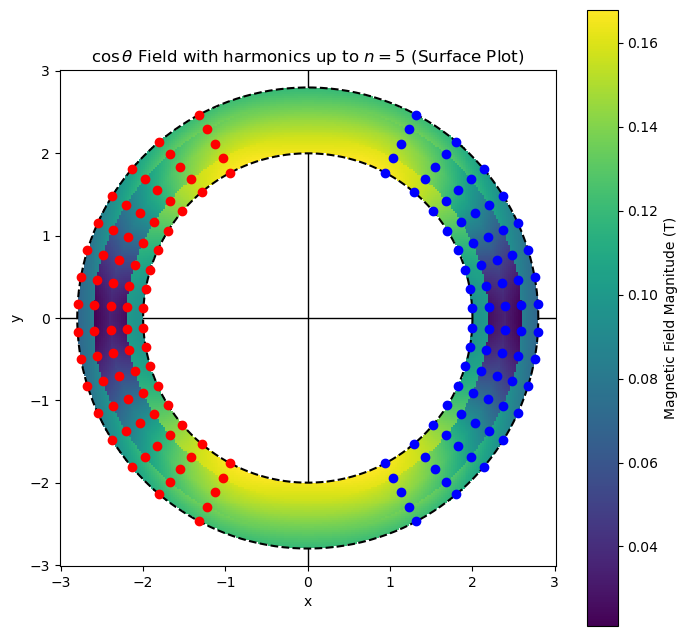

In [7]:
# Grid setup
x = np.linspace(-3, 3, 250)
y = np.linspace(-3, 3, 250)
X, Y = np.meshgrid(x, y)

Bx_total = np.zeros_like(X)
By_total = np.zeros_like(Y)

# Calculate field for each wire component
for x0, y0, I in wire_params:
    Bx, By = B_harm(X, Y, x0, y0, I)
    Bx_total += Bx
    By_total += By

# Total B-field magnitudes are computed
B_mag = np.sqrt(Bx_total**2 + By_total**2)

####################################################################################
# Plotting

plt.figure(figsize=(8, 8))

# Surface plot using pcolormesh
# Mask values outside the toroidal region for clarity
mask = (X**2 + Y**2 >= r0**2) & (X**2 + Y**2 <= outer_radius**2)
B_mag_masked = np.where(mask, B_mag, np.nan)

# Create the surface plot (can switch to B_mag_masked)
pcm = plt.pcolormesh(X, Y, B_mag_masked, shading='auto', cmap='viridis')
cbar = plt.colorbar(pcm, label='Magnetic Field Magnitude (T)')

# Plot conductors
for x0, y0, I in wire_params:
    color = 'r' if I > 0 else 'b'
    plt.plot(x0, y0, 'o', color=color)

# Draw inner and outer boundary circles
theta_circle = np.linspace(0, 2 * np.pi, 500)
x_inner = r0 * np.cos(theta_circle)
y_inner = r0 * np.sin(theta_circle)
x_outer = outer_radius * np.cos(theta_circle)
y_outer = outer_radius * np.sin(theta_circle)
plt.plot(x_inner, y_inner, 'k--', zorder=1)
plt.plot(x_outer, y_outer, 'k--', zorder=1)

# Axis styling
plt.axhline(0, color='black', linewidth=1, zorder=0)
plt.axvline(0, color='black', linewidth=1, zorder=0)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"$\\cos \\theta$ Field with harmonics up to $n={n_max}$ (Surface Plot)")
plt.show()



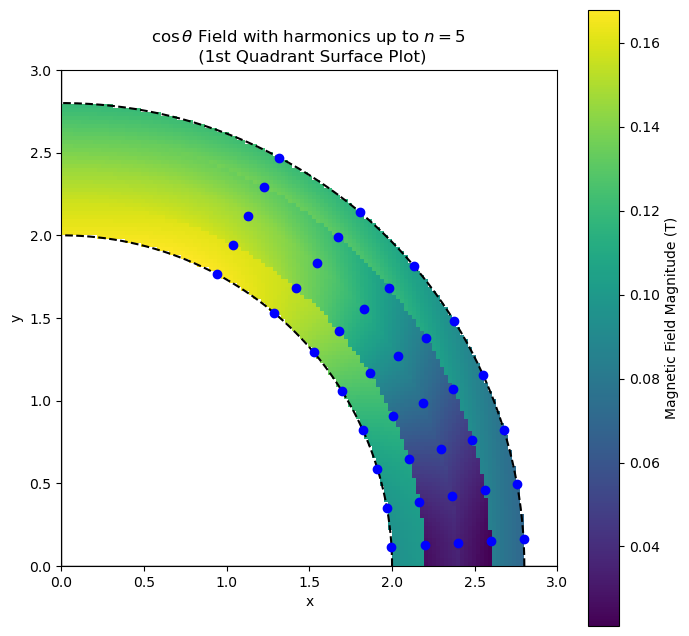

In [8]:
# First quadrant surface plot

# Grid setup
x = np.linspace(-3, 3, 250)
y = np.linspace(-3, 3, 250)
X, Y = np.meshgrid(x, y)

Bx_total = np.zeros_like(X)
By_total = np.zeros_like(Y)

# Calculate field for each wire component
for x0, y0, I in wire_params:
    Bx, By = B_harm(X, Y, x0, y0, I)  # ← use your B_harm function here
    Bx_total += Bx
    By_total += By


# Total B-field magnitudes are computed
B_mag = np.sqrt(Bx_total**2 + By_total**2)

####################################################################################
# Plotting

plt.figure(figsize=(8, 8))

# Surface plot using pcolormesh
# Mask values outside the toroidal region for clarity
mask = (X**2 + Y**2 >= r0**2) & (X**2 + Y**2 <= outer_radius**2)
B_mag_masked = np.where(mask, B_mag, np.nan)

# Create the surface plot (can switch to B_mag_masked)
pcm = plt.pcolormesh(X, Y, B_mag_masked, shading='auto', cmap='viridis')
cbar = plt.colorbar(pcm, label='Magnetic Field Magnitude (T)')

# Plot conductors
for x0, y0, I in wire_params:
    color = 'r' if I > 0 else 'b'
    plt.plot(x0, y0, 'o', color=color)

# Draw inner and outer boundary circles
theta_circle = np.linspace(0, 2 * np.pi, 500)
x_inner = r0 * np.cos(theta_circle)
y_inner = r0 * np.sin(theta_circle)
x_outer = outer_radius * np.cos(theta_circle)
y_outer = outer_radius * np.sin(theta_circle)
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.plot(x_inner, y_inner, 'k--', zorder=1)
plt.plot(x_outer, y_outer, 'k--', zorder=1)

# Axis styling
plt.axhline(0, color='black', linewidth=1, zorder=0)
plt.axvline(0, color='black', linewidth=1, zorder=0)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"$\\cos \\theta$ Field with harmonics up to $n={n_max}$ \n (1st Quadrant Surface Plot)")
plt.show()



## 6. Isolated Sextupole Component

Note that for a dipole configuration, even order harmonics are not allowed.

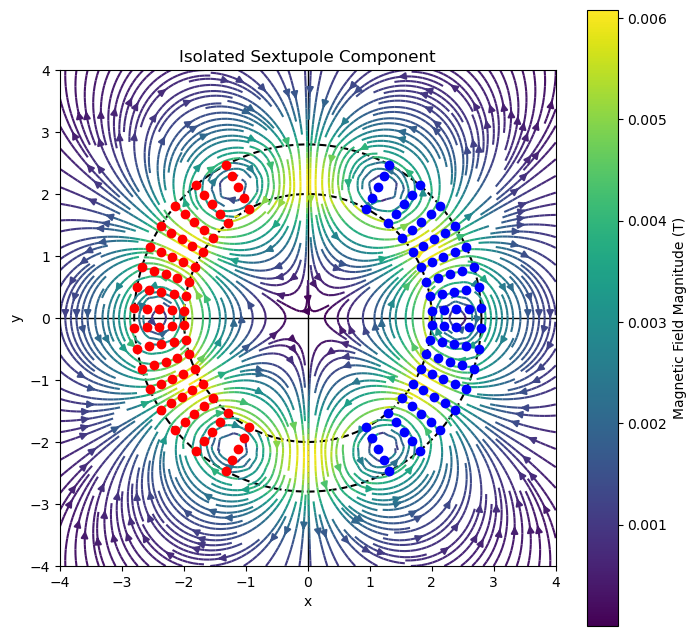

In [9]:
x = np.linspace(-4, 4, 250)
y = np.linspace(-4, 4, 250)
X, Y = np.meshgrid(x, y)

Bx_total = np.zeros_like(X)
By_total = np.zeros_like(Y)

# Calculate field for each wire component
for x0, y0, I in wire_params:
    Bx, By = B_harm_indiv(X, Y, x0, y0, I, 3)
    Bx_total += Bx
    By_total += By

# Total B-field magnitudes are computed
B_mag = np.sqrt(Bx_total**2 + By_total**2)

####################################################################################
# Plotting
plt.figure(figsize=(8, 8))

# Stream plot of magnetic field
# Only shows 95th percentile as max to make line magnitudes easier to see
#norm = mcolors.Normalize(vmin=B_mag.min(), vmax=np.percentile(B_mag, 95)) 
strm = plt.streamplot(X, Y, Bx_total, By_total, color=B_mag, cmap='viridis', density=3)
cbar = plt.colorbar(strm.lines, label='Magnetic Field Magnitude (T)')

# Plot conductors
for x0, y0, I in wire_params:
    color = 'r' if I > 0 else 'b'
    plt.plot(x0, y0, 'o', color=color)

# Draw inner circle (optional reference)
theta_circle = np.linspace(0, 2*np.pi, 500)
x_circle = r0 * np.cos(theta_circle)
y_circle = r0 * np.sin(theta_circle)
plt.plot(x_circle, y_circle, 'k--', zorder=0)

# Draw outer circle to contain all conductors (defined by number of conductors)
outer_radius = r0 + (n_radial - 1) * dr
theta_circle = np.linspace(0, 2 * np.pi, 500)
x_outer = outer_radius * np.cos(theta_circle)
y_outer = outer_radius * np.sin(theta_circle)
plt.plot(x_outer, y_outer, 'k--', zorder=0)

# Axes & final layout
plt.axhline(0, color='black', linewidth=1, zorder=0)
plt.axvline(0, color='black', linewidth=1, zorder=0)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Isolated Sextupole Component")
plt.show()


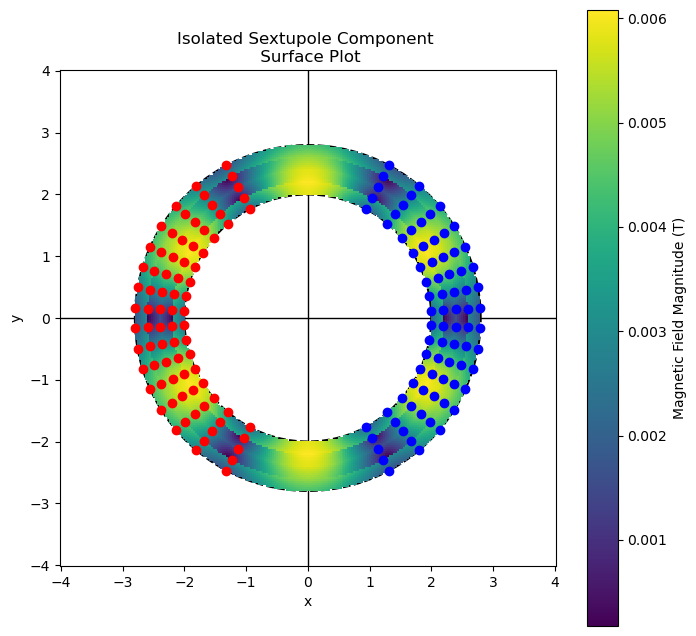

In [10]:
# Grid setup
x = np.linspace(-4, 4, 250)
y = np.linspace(-4, 4, 250)
X, Y = np.meshgrid(x, y)

Bx_total = np.zeros_like(X)
By_total = np.zeros_like(Y)

# Calculate field for each wire component
for x0, y0, I in wire_params:
    Bx, By = B_harm_indiv(X, Y, x0, y0, I, 3)
    Bx_total += Bx
    By_total += By


# Total B-field magnitudes are computed
B_mag = np.sqrt(Bx_total**2 + By_total**2)

####################################################################################
# Plotting

plt.figure(figsize=(8, 8))

# Stream plot of magnetic field
# Only shows 95th percentile as max to make line magnitudes easier to see
mask = (X**2 + Y**2 >= r0**2) & (X**2 + Y**2 <= outer_radius**2)
B_mag_masked = np.where(mask, B_mag, np.nan)

# Create the surface plot (can switch to B_mag_masked)
pcm = plt.pcolormesh(X, Y, B_mag_masked, shading='auto', cmap='viridis')
cbar = plt.colorbar(pcm, label='Magnetic Field Magnitude (T)')

# Plot conductors
for x0, y0, I in wire_params:
    color = 'r' if I > 0 else 'b'
    plt.plot(x0, y0, 'o', color=color)

# Draw inner circle (optional reference)
theta_circle = np.linspace(0, 2*np.pi, 500)
x_circle = r0 * np.cos(theta_circle)
y_circle = r0 * np.sin(theta_circle)
plt.plot(x_circle, y_circle, 'k--', zorder=0)

# Draw outer circle to contain all conductors (defined by number of conductors)
outer_radius = r0 + (n_radial - 1) * dr
theta_circle = np.linspace(0, 2 * np.pi, 500)
x_outer = outer_radius * np.cos(theta_circle)
y_outer = outer_radius * np.sin(theta_circle)
plt.plot(x_outer, y_outer, 'k--', zorder=0)

# Axes & final layout
plt.axhline(0, color='black', linewidth=1, zorder=0)
plt.axvline(0, color='black', linewidth=1, zorder=0)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Isolated Sextupole Component \n Surface Plot")
plt.show()

## 7. Isolated Higher Order Components

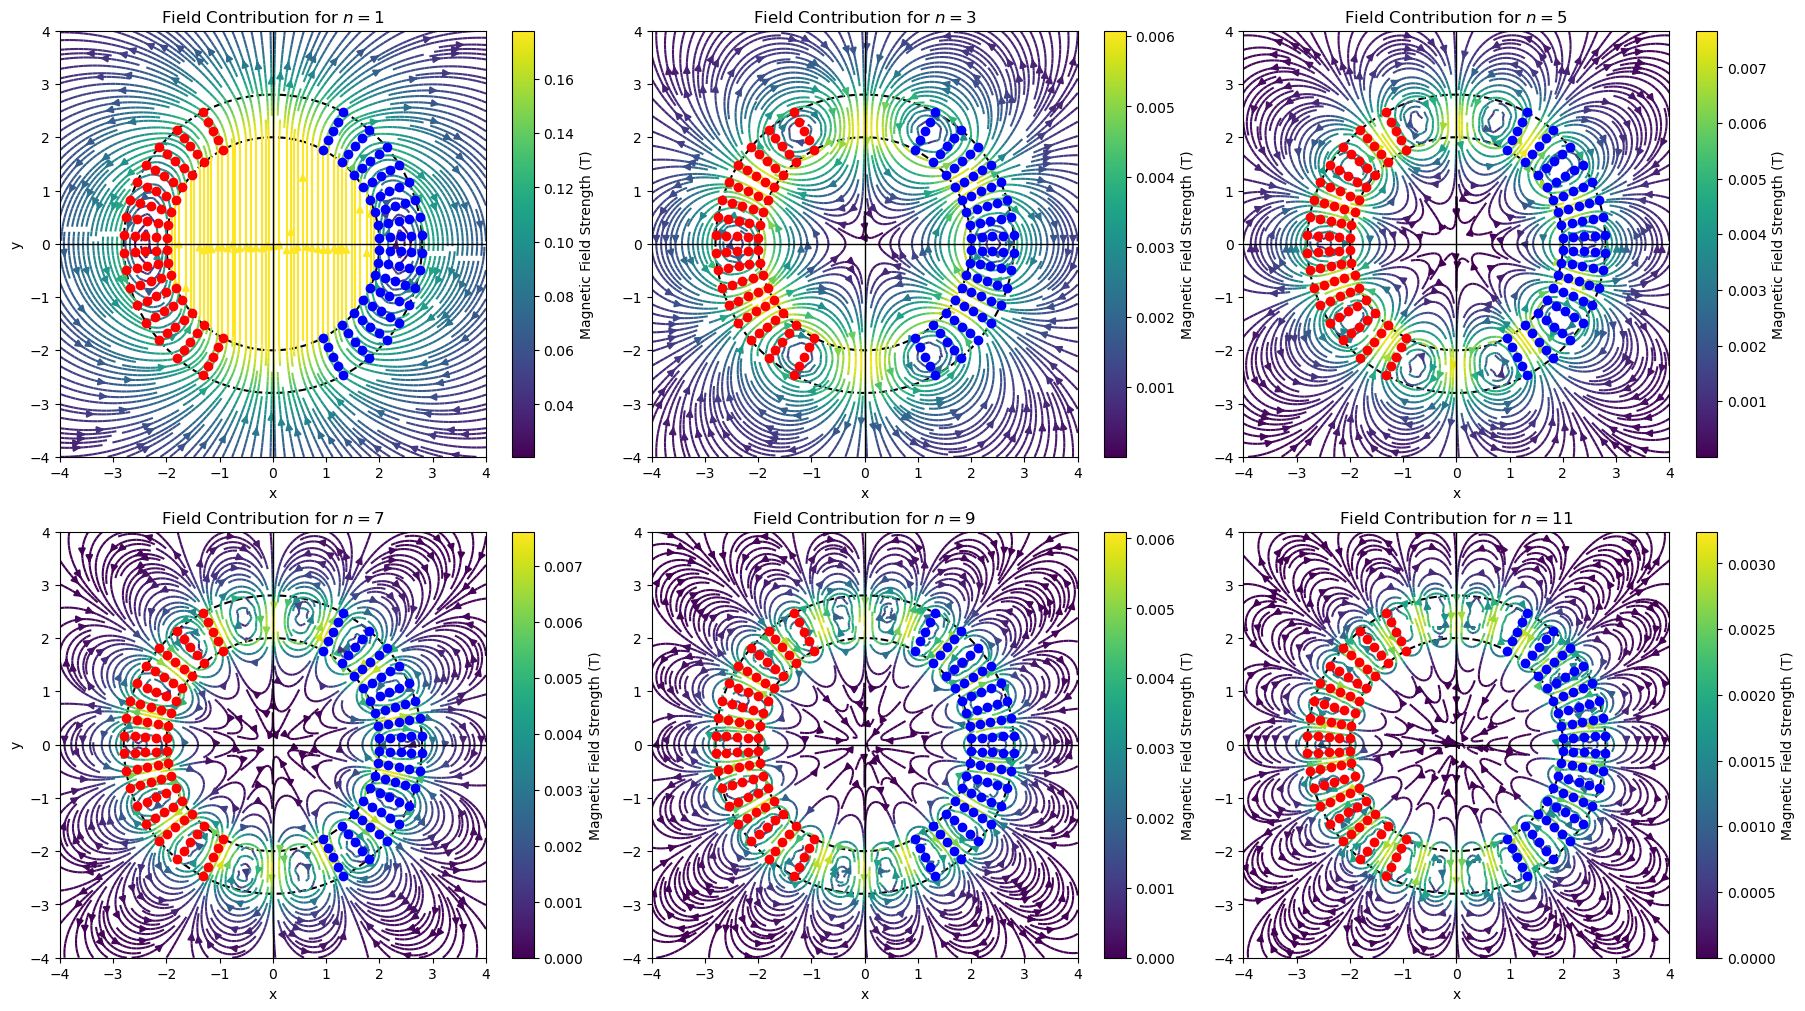

In [11]:
# Grid for field plotting
# Increasing this resolution will improve calculation precision
x = np.linspace(-4, 4, 250)
y = np.linspace(-4, 4, 250)
X, Y = np.meshgrid(x, y)

# Circles for reference
theta_circle = np.linspace(0, 2 * np.pi, 500)
x_circle = r0 * np.cos(theta_circle)
y_circle = r0 * np.sin(theta_circle)
outer_radius = r0 + (n_radial - 1) * dr
x_outer = outer_radius * np.cos(theta_circle)
y_outer = outer_radius * np.sin(theta_circle)

# Set up figure and axes: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
axes = axes.flatten()

# Loop over harmonics n = 1 to 6
for idx, n in enumerate([1, 3, 5, 7, 9, 11]):
    Bx_total = np.zeros_like(X)
    By_total = np.zeros_like(Y)

    for x0, y0, I in wire_params:
        Bx, By = B_harm_indiv(X, Y, x0, y0, I, n)
        Bx_total += Bx
        By_total += By

    B_mag = np.sqrt(Bx_total**2 + By_total**2)

    ax = axes[idx]
    ax.set_title(f"Field Contribution for $n = {n}$")

    #norm = mcolors.Normalize(vmin=B_mag.min(), vmax=np.percentile(B_mag, 95))
    strm = ax.streamplot(X, Y, Bx_total, By_total, color=B_mag, cmap='viridis', density=3)
    fig.colorbar(strm.lines, ax=ax, orientation='vertical', label='Magnetic Field Strength (T)')

    for x0, y0, I in wire_params:
        color = 'r' if I > 0 else 'b'
        ax.plot(x0, y0, 'o', color=color)

    ax.plot(x_circle, y_circle, 'k--', zorder=0)
    ax.plot(x_outer, y_outer, 'k--', zorder=0)
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(0, color='black', linewidth=1)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    if idx % 3 == 0:  # First column
        ax.set_ylabel("y")

plt.show()



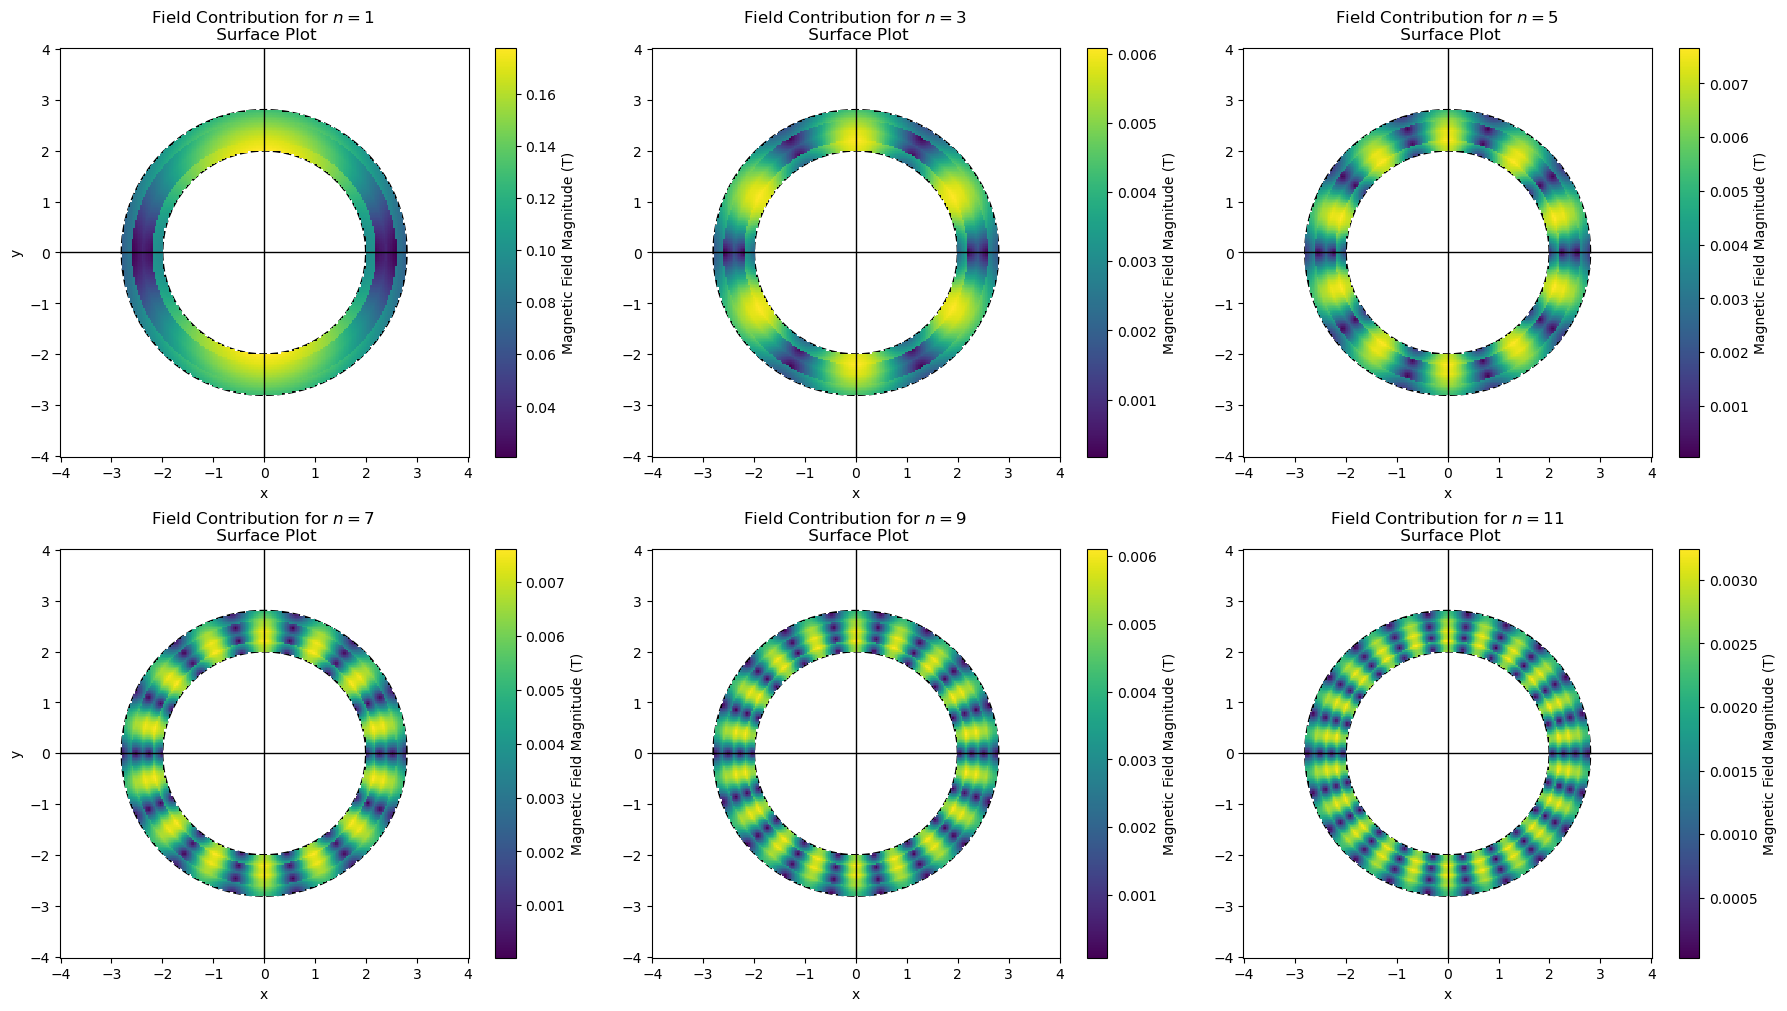

In [12]:
# Grid for field plotting
# Increasing this resolution will improve calculation precision
x = np.linspace(-4, 4, 250)
y = np.linspace(-4, 4, 250)
X, Y = np.meshgrid(x, y)

# Circles for reference
theta_circle = np.linspace(0, 2 * np.pi, 500)
x_circle = r0 * np.cos(theta_circle)
y_circle = r0 * np.sin(theta_circle)
outer_radius = r0 + (n_radial - 1) * dr
x_outer = outer_radius * np.cos(theta_circle)
y_outer = outer_radius * np.sin(theta_circle)

# Set up figure and axes: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
axes = axes.flatten()

# Loop over harmonics n = 1 to 5
for idx, n in enumerate([1, 3, 5, 7, 9, 11]):
    Bx_total = np.zeros_like(X)
    By_total = np.zeros_like(Y)

    for x0, y0, I in wire_params:
        Bx, By = B_harm_indiv(X, Y, x0, y0, I, n)
        Bx_total += Bx
        By_total += By

    B_mag = np.sqrt(Bx_total**2 + By_total**2)

    ax = axes[idx]
    ax.set_title(f"Field Contribution for $n = {n}$ \n Surface Plot")

    mask = (X**2 + Y**2 >= r0**2) & (X**2 + Y**2 <= outer_radius**2)
    B_mag_masked = np.where(mask, B_mag, np.nan)
    
    # Create the surface plot (can switch to B_mag_masked)
    pcm = ax.pcolormesh(X, Y, B_mag_masked, shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=ax, label='Magnetic Field Magnitude (T)')

    ax.plot(x_circle, y_circle, 'k--', zorder=0)
    ax.plot(x_outer, y_outer, 'k--', zorder=0)
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(0, color='black', linewidth=1)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    if idx % 3 == 0:  # First column
        ax.set_ylabel("y")

plt.show()



## 8. Plotting Conductors as Blocks:

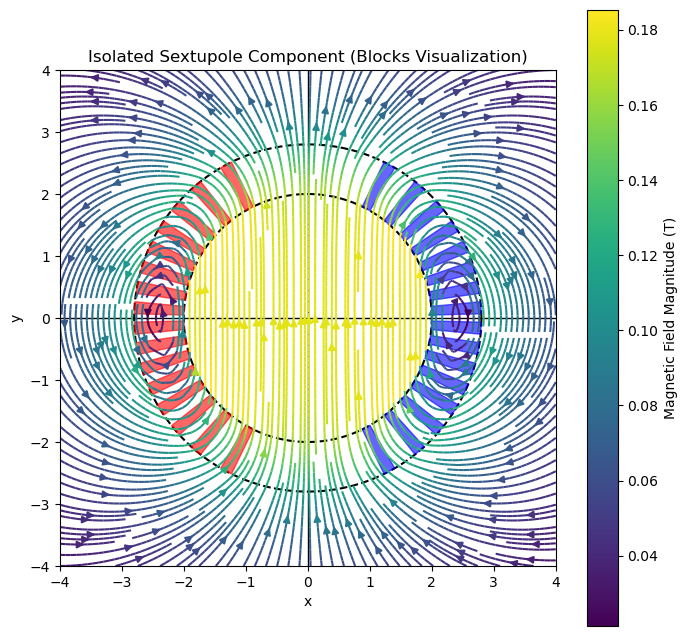

In [13]:
from matplotlib.patches import Polygon
# B-field components are computed

# We set them up as arrays with the same dimensions as X and Y

# Grid setup
x = np.linspace(-4, 4, 250)
y = np.linspace(-4, 4, 250)
X, Y = np.meshgrid(x, y)

Bx_total = np.zeros_like(X)
By_total = np.zeros_like(Y)

# Calculate field for each wire component
for x0, y0, I in wire_params:
    Bx, By = B_harm(X, Y, x0, y0, I)
    Bx_total += Bx
    By_total += By


# Total B-field magnitudes are computed
B_mag = np.sqrt(Bx_total**2 + By_total**2)

####################################################################################
# Plotting

plt.figure(figsize=(8, 8))

"""
# Plot conductors
for x0, y0, I in wire_params:
    color = 'r' if I > 0 else 'b'
    plt.plot(x0, y0, 'o', color=color)
"""

# Stream plot of magnetic field
strm = plt.streamplot(X, Y, Bx_total, By_total, color=B_mag, cmap='viridis', density=3)
cbar = plt.colorbar(strm.lines, label='Magnetic Field Magnitude (T)')

# === Plot BLOCKS as polygons (wedge-shaped) ===
for theta in theta_list:
    dtheta = np.deg2rad(2)  # visual angular width of block
    r_inner = r0
    r_outer = r0 + (n_radial - 1) * dr

    # Define 4 corners of the wedge-like block
    x1 = r_inner * np.cos(theta - dtheta)
    y1 = r_inner * np.sin(theta - dtheta)
    x2 = r_outer * np.cos(theta - dtheta)
    y2 = r_outer * np.sin(theta - dtheta)
    x3 = r_outer * np.cos(theta + dtheta)
    y3 = r_outer * np.sin(theta + dtheta)
    x4 = r_inner * np.cos(theta + dtheta)
    y4 = r_inner * np.sin(theta + dtheta)

    color = 'red' if np.cos(theta) < 0 else 'blue'  # left side = red (positive current), right = blue (negative)
    polygon = Polygon([[x1, y1], [x2, y2], [x3, y3], [x4, y4]],
                      closed=True, color=color, alpha=0.6)
    plt.gca().add_patch(polygon)

# Optional: draw inner and outer reference circles
theta_circle = np.linspace(0, 2 * np.pi, 500)
x_inner = r0 * np.cos(theta_circle)
y_inner = r0 * np.sin(theta_circle)
x_outer = (r0 + (n_radial - 1) * dr) * np.cos(theta_circle)
y_outer = (r0 + (n_radial - 1) * dr) * np.sin(theta_circle)
plt.plot(x_inner, y_inner, 'k--', zorder=0)
plt.plot(x_outer, y_outer, 'k--', zorder=0)

# Axes setup
plt.axhline(0, color='black', linewidth=1, zorder=0)
plt.axvline(0, color='black', linewidth=1, zorder=0)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Isolated Sextupole Component (Blocks Visualization)")
plt.show()

## 9. Field Quality Calculations:

We define the field quality as: 
* $b_n=\dfrac{B_n}{B_\text{ref}}\cdot10^4$

Here, $B_\text{ref}$ is the main field we are normalizing with respect to. This equation allows us to normalize the field quality do the main field is in units of 10,000 and the other field components are in units of 1's.

In [14]:
# Grid for B-field
x = np.linspace(-4, 4, 250)
y = np.linspace(-4, 4, 250)
X, Y = np.meshgrid(x, y)

# Compute max field magnitude for each harmonic n
max_fields = []

for n in [1, 3, 5, 7, 9, 11]:
    Bx_total = np.zeros_like(X)
    By_total = np.zeros_like(Y)

    for x0, y0, I in wire_params:
        Bx, By = B_harm_indiv(X, Y, x0, y0, I, n)
        Bx_total += Bx
        By_total += By

    B_mag = np.sqrt(Bx_total**2 + By_total**2)
    max_B = np.max(B_mag)
    max_fields.append(max_B)

# Do we want to note the max field contribution for each harmonic?
print("Maximum B-field magnitudes for n = 1, 3, 5, 7, 9, 11:", max_fields)


Maximum B-field magnitudes for n = 1, 3, 5, 7, 9, 11: [0.17783858094460062, 0.006080188426349884, 0.007659219234476081, 0.0076186705737227725, 0.006099832284904115, 0.003243225416249961]


In [15]:
# Grid for B-field
x = np.linspace(-4, 4, 250)
y = np.linspace(-4, 4, 250)
X, Y = np.meshgrid(x, y)

# Compute max field magnitude for each harmonic n
max_fields = []

b_qual = []
b_qual_max = []


for n in [1, 3, 5, 7, 9, 11]:
    Bx_total = np.zeros_like(X)
    By_total = np.zeros_like(Y)

    for x0, y0, I in wire_params:
        Bx, By = B_harm_indiv(X, Y, x0, y0, I, n)
        Bx_total += Bx
        By_total += By
    
    B_mag = np.sqrt(Bx_total**2 + By_total**2)
    
    if n == 1:
        # Isolate the reference magnitude
        B_ref_mag = np.sqrt(Bx_total**2 + By_total**2)
    else:
        pass

    b_qual.append( (B_mag/B_ref_mag)*(10**4) )

harmonics = [1, 3, 5, 7, 9, 11]
for n, lis in zip(harmonics, b_qual): # zip combines values into tuples
    print(f"n={n} Max Field Quality: {np.max(lis)}")



n=1 Max Field Quality: 10000.0
n=3 Max Field Quality: 871.6099216164782
n=5 Max Field Quality: 1600.7803491603183
n=7 Max Field Quality: 1959.4074122659054
n=9 Max Field Quality: 1747.9853794031428
n=11 Max Field Quality: 1061.7263885440013


## 10. Input Values:

In [16]:
# Try different distributions
# Need to normalize to 10^4 units
# Make surface plot of Lorrentz force ?
# Move on to field quality calculations, with the 10^4 factor that is used

# For input: We want to be able to give number of blocks and number of layers, and still have it follow the cosine theta distribution

## Miscellaneous Testing:

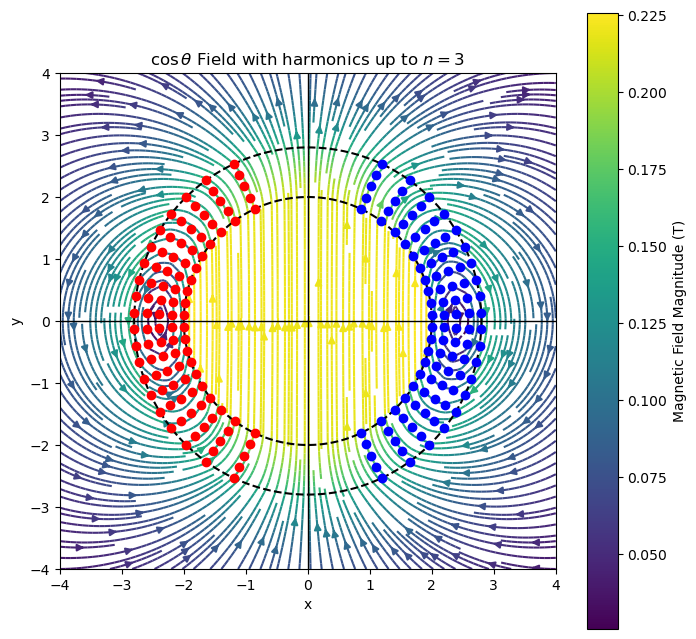

In [17]:
# Here, we define the B-field in terms of its harmonic components
# Max N value for the harmonic series
n_max = 3

def B_harm(x, y, x_a, y_a, I):
    r = np.sqrt(x**2 + y**2)
    a = np.sqrt(x_a**2 + y_a**2)

    phi = np.arctan2(y_a, x_a)
    theta = np.arctan2(y, x)

    ang = phi - theta

    # Avoid division by zero
    r = np.where(r == 0, 1e-10, r)

    # Compute terms for both cases

    # Case for r > a:
    B_r_out = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(a / r)**(n + 1) * np.sin(n * ang) for n in range(0, n_max+1)], axis=0)
    B_theta_out = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(a / r)**(n + 1) * np.cos(n * ang) for n in range(0, n_max+1)], axis=0)

    # Case for r < a:
    B_r_in = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(r / a)**(n - 1) * np.sin(n * ang) for n in range(1, n_max+1)], axis=0)
    B_theta_in = (-1)*((mu0 * I) / (2 * np.pi * a)) * np.sum([(r / a)**(n - 1) * np.cos(n * ang) for n in range(1, n_max+1)], axis=0)

    # Use np.where to select the correct values
    # np.where(cond., x, y) -> # If true, takes x; if false, takes y
    
    B_r = np.where(r > a, B_r_out, B_r_in) 
    B_theta = np.where(r > a, B_theta_out, B_theta_in)

    # Convert to cartesian coordinates
    B_x = B_r * np.cos(theta) - B_theta * np.sin(theta)
    B_y = B_r * np.sin(theta) + B_theta * np.cos(theta)

    return B_x, B_y

##################################################################################################

# Constants
mu0 = 4 * np.pi * 1e-7 # Vacuum permeability
r0 = 2 # Radius from origin as starting point (inner layer)
# Outter radius is controlled by amount of condutors present in block
blocks_per_quad = 10
num_conductors = blocks_per_quad * 4 # Total number of blocks (divide by 4 to get number of blocks per quadrant)
n_radial = 5 # Number of conductors per block
dr = 0.2 # Radial spacing of conductors
I0 = 16000 # Current magnitude

# List of angles following a cosine theta distribution, symmetric about y axis

# Total number of conductors per side
half_conductors = num_conductors // 2 

# Uniformly spaced cumulative values (excluding 0 and 1 to avoid endpoints)
u = np.linspace(0, 1, half_conductors + 2)[1:-1]

# Inverse CDF: arcsin(2u - 1) maps uniform u to theta
theta_right = np.arcsin(2 * u - 1)         # Right side: theta in [-π/2, π/2]
theta_left = np.pi - theta_right           # Reflect to left side for symmetry

theta_list = np.sort(np.concatenate([theta_right, theta_left]))


# Determines the position of the conductors from the given angles
radii = [r0 + i * dr for i in range(n_radial)]

# Maps out the wires and how they should be distributed
wire_params = []
for theta in theta_list:
    for r in radii:
        x = r * np.cos(theta)
        y = r * np.sin(theta)

        # Determine current direction by quadrant
        if x > 0:
            current = (-1)*I0  # Q1 & Q4 (right side)
        elif x < 0:
            current = I0   # Q2 & Q3 (left side)
        else:
            current = 0  # Edge case — not expected
        wire_params.append((x, y, current))

# B-field components are computed

# We set them up as arrays with the same dimensions as X and Y

# Grid setup
x = np.linspace(-4, 4, 250)
y = np.linspace(-4, 4, 250)
X, Y = np.meshgrid(x, y)

Bx_total = np.zeros_like(X)
By_total = np.zeros_like(Y)

# Calculate field for each wire component
for x0, y0, I in wire_params:
    Bx, By = B_harm(X, Y, x0, y0, I)
    Bx_total += Bx
    By_total += By


# Total B-field magnitudes are computed
B_mag = np.sqrt(Bx_total**2 + By_total**2)

####################################################################################
# Plotting

plt.figure(figsize=(8, 8))

# Stream plot of magnetic field
# Only shows 95th percentile as max to make line magnitudes easier to see
#norm = mcolors.Normalize(vmin=B_mag.min(), vmax=np.percentile(B_mag, 95)) 
strm = plt.streamplot(X, Y, Bx_total, By_total, color=B_mag, cmap='viridis', density=3)
cbar = plt.colorbar(strm.lines, label='Magnetic Field Magnitude (T)')

# Plot conductors
for x0, y0, I in wire_params:
    color = 'r' if I > 0 else 'b'
    plt.plot(x0, y0, 'o', color=color, zorder=6)

# Draw inner circle
theta_circle = np.linspace(0, 2*np.pi, 500)
x_circle = (r0) * np.cos(theta_circle)
y_circle = (r0) * np.sin(theta_circle)
plt.plot(x_circle, y_circle, 'k--', zorder=5)

# Draw outer circle to contain all conductors
outer_radius = r0 + (n_radial - 1) * dr
theta_circle = np.linspace(0, 2 * np.pi, 500)
x_outer = outer_radius * np.cos(theta_circle)
y_outer = outer_radius * np.sin(theta_circle)
plt.plot(x_outer, y_outer, 'k--', zorder=5)

# Axes & final layout
plt.axhline(0, color='black', linewidth=1, zorder=5)
plt.axvline(0, color='black', linewidth=1, zorder=5)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"$\\cos \\theta$ Field with harmonics up to $n=${n_max}")
plt.show()


In [18]:
# Added ability to adjust conductor spacing with walls

# Here, we define the B-field in terms of its harmonic components
# Max N value for the harmonic series
n_max = 3

def B_harm(x, y, x_a, y_a, I):
    r = np.sqrt(x**2 + y**2)
    a = np.sqrt(x_a**2 + y_a**2)

    phi = np.arctan2(y_a, x_a)
    theta = np.arctan2(y, x)

    ang = phi - theta

    # Avoid division by zero
    r = np.where(r == 0, 1e-10, r)

    # Compute terms for both cases

    # Case for r > a:
    B_r_out = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(a / r)**(n + 1) * np.sin(n * ang) for n in range(0, n_max+1)], axis=0)
    B_theta_out = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(a / r)**(n + 1) * np.cos(n * ang) for n in range(0, n_max+1)], axis=0)

    # Case for r < a:
    B_r_in = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(r / a)**(n - 1) * np.sin(n * ang) for n in range(1, n_max+1)], axis=0)
    B_theta_in = (-1)*((mu0 * I) / (2 * np.pi * a)) * np.sum([(r / a)**(n - 1) * np.cos(n * ang) for n in range(1, n_max+1)], axis=0)

    # Use np.where to select the correct values
    # np.where(cond., x, y) -> # If true, takes x; if false, takes y
    
    B_r = np.where(r > a, B_r_out, B_r_in) 
    B_theta = np.where(r > a, B_theta_out, B_theta_in)

    # Convert to cartesian coordinates
    B_x = B_r * np.cos(theta) - B_theta * np.sin(theta)
    B_y = B_r * np.sin(theta) + B_theta * np.cos(theta)

    return B_x, B_y

##################################################################################################

# Constants
mu0 = 4 * np.pi * 1e-7 # Vacuum permeability
r0 = 2 # Radius from origin as starting point (inner layer)
# Outter radius is controlled by amount of condutors present in block
num_conductors = 32 # Total number of blocks (divide by 4 to get number of blocks per quadrant)
n_radial = 5 # Number of conductors per block

dr_in = 0
dr_out = 0
dr = 0.7 # Radial spacing of conductors


I0 = 16000 # Current magnitude

# List of angles following a cosine theta distribution, symmetric about y axis

# Total number of conductors per side
half_conductors = num_conductors // 2 

# Uniformly spaced cumulative values (excluding 0 and 1 to avoid endpoints)
u = np.linspace(0, 1, half_conductors + 2)[1:-1]

# Inverse CDF: arcsin(2u - 1) maps uniform u to theta
theta_right = np.arcsin(2 * u - 1)         # Right side: theta in [-π/2, π/2]
theta_left = np.pi - theta_right           # Reflect to left side for symmetry

theta_list = np.sort(np.concatenate([theta_right, theta_left]))

# Determines the position of the conductors from the given angles
radii = [r0 + i * dr for i in range(n_radial)]

# Maps out the wires and how they should be distributed
wire_params = []
for theta in theta_filtered:
    for r in radii:
        x = r * np.cos(theta)
        y = r * np.sin(theta)

        # Determine current direction by quadrant
        if x > 0:
            current = (-1)*I0  # Q1 & Q4 (right side)
        elif x < 0:
            current = I0   # Q2 & Q3 (left side)
        else:
            current = 0  # Edge case — not expected
        wire_params.append((x, y, current))

# B-field components are computed

# We set them up as arrays with the same dimensions as X and Y

# Grid setup
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x, y)

Bx_total = np.zeros_like(X)
By_total = np.zeros_like(Y)

# Calculate field for each wire component
for x0, y0, I in wire_params:
    Bx, By = B_harm(X, Y, x0, y0, I)  # ← use your B_harm function here
    Bx_total += Bx
    By_total += By


# Total B-field magnitudes are computed
B_mag = np.sqrt(Bx_total**2 + By_total**2)

####################################################################################
# Plotting

plt.figure(figsize=(8, 8))

# Stream plot of magnetic field
# Only shows 95th percentile as max to make line magnitudes easier to see
#norm = mcolors.Normalize(vmin=B_mag.min(), vmax=np.percentile(B_mag, 95)) 

"""
# Plot conductors
for x0, y0, I in wire_params:
    color = 'r' if I > 0 else 'b'
    plt.plot(x0, y0, 'o', color=color)
"""

# Draw inner circle
theta_circle = np.linspace(0, 2*np.pi, 500)
x_circle = (r0 - dr_in) * np.cos(theta_circle)
y_circle = (r0 - dr_in) * np.sin(theta_circle)
plt.plot(x_circle, y_circle, 'k--', zorder=0)

# Draw outer circle to contain all conductors
outer_radius = r0 + (n_radial - 1) * dr + dr_out
theta_circle = np.linspace(0, 2 * np.pi, 500)
x_outer = outer_radius * np.cos(theta_circle)
y_outer = outer_radius * np.sin(theta_circle)
plt.plot(x_outer, y_outer, 'k--', zorder=0)

mask = (X**2 + Y**2 >= (r0 - dr_in)**2) & (X**2 + Y**2 <= outer_radius**2)
B_mag_masked = np.where(mask, B_mag, np.nan)

# Create the surface plot (can switch to B_mag_masked)
pcm = plt.pcolormesh(X, Y, B_mag_masked, shading='auto', cmap='viridis')
cbar = plt.colorbar(pcm, label='Magnetic Field Magnitude (T)')


# Axes & final layout
plt.axhline(0, color='black', linewidth=1, zorder=0)
plt.axvline(0, color='black', linewidth=1, zorder=0)
plt.gca().set_aspect('equal')
#plt.xlim(0, 3)
#plt.ylim(0, 3)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"$\\cos \\theta$ Field with harmonics up to $n=${n_max}")
plt.show()


NameError: name 'theta_filtered' is not defined